# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
!pip install pandas==0.23.4

In [2]:
# y = 'health outcome' - predicted variable - dependent variable
# x = 'drug usage' - explanatory variable - independent variable

In [3]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_os',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [4]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [5]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=205.20589013315842, mobile=False), User(purchased=True, time_on_site=551.7482887994896, mobile=False), User(purchased=False, time_on_site=117.73533886204673, mobile=True), User(purchased=True, time_on_site=392.80431739918447, mobile=False), User(purchased=True, time_on_site=290.5368775750057, mobile=True), User(purchased=False, time_on_site=315.8625400256949, mobile=False), User(purchased=False, time_on_site=174.87695158983394, mobile=False), User(purchased=False, time_on_site=230.77935215857036, mobile=True), User(purchased=False, time_on_site=81.73151399176976, mobile=True), User(purchased=False, time_on_site=9.46683039729289, mobile=True)]


In [15]:
import pandas as pd
import seaborn as sns

In [6]:
# Let's put this in a dataframe so we can look at it more easily

user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,205.205890,False
1,True,551.748289,False
2,False,117.735339,True
3,True,392.804317,False
4,True,290.536878,True


In [7]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.202549528639741,5.883882832949513,6.11746570180323,6.255143352528734,6.753270098677946,7.44731572819517,7.571020963461605,7.617019323514672,8.296794174491644,8.335284437239928,...,578.0583665463738,582.5608563844789,584.1317030937888,586.4257931918572,589.1448827817018,589.8777766625457,591.3809135358961,596.9069117005898,597.0556561013364,598.916505253927
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,0,1,1,0,1,0
True,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,1,0,0,1,0,1


In [8]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.609, 123.945]","(123.945, 242.688]","(242.688, 361.431]","(361.431, 480.174]","(480.174, 598.917]"
purchased,,,,,
False,243,211,106,22,30
True,104,159,80,19,26


In [9]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.609, 123.945]","(123.945, 242.688]","(242.688, 361.431]","(361.431, 480.174]","(480.174, 598.917]"
purchased,,,,,
False,0.700288,0.57027,0.569892,0.536585,0.535714
True,0.299712,0.42973,0.430108,0.463415,0.464286


In [10]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.672,0.592
True,0.328,0.408


In [11]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins],
           rownames=['device'],
           colnames=['purchased','time on site'],
           normalize='index') 

purchased               False                                        \
time on site (4.609, 123.945] (123.945, 242.688] (242.688, 361.431]   
device                                                                
False                   0.168           0.168000           0.128000   
True                    0.268           0.225333           0.098667   

purchased                                                     True   \
time on site (361.431, 480.174] (480.174, 598.917] (4.609, 123.945]   
device                                                                
False                     0.088               0.12         0.024000   
True                      0.000               0.00         0.130667   

purchased                                                              \
time on site (123.945, 242.688] (242.688, 361.431] (361.431, 480.174]   
device                                                                  
False                  0.068000              0.056              0.076   
True                   0.189333              0.088              0.000   

purchased                        
time on site (480.174, 598.917]  
device                           
False                     0.104  
True                      0.000

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [35]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df = pd.read_csv('https://raw.githubusercontent.com/dwightchurchill/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')
df = df.rename(columns={'Unnamed: 0':'ID'})
df.head()


,ID,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [101]:
exercise_time_bins = pd.cut(df.exercise_time,5)
age_bins = pd.cut(df.age,5)
weight_bins = pd.cut(df.weight,2)

In [105]:
pd.crosstab(exercise_time_bins,[age_bins,weight_bins],
            normalize='columns')

age             (17.938, 30.4]                   (30.4, 42.8]                   (42.8, 55.2]                   (55.2, 67.6]                   (67.6, 80.0]               
weight         (99.854, 173.0] (173.0, 246.0] (99.854, 173.0] (173.0, 246.0] (99.854, 173.0] (173.0, 246.0] (99.854, 173.0] (173.0, 246.0] (99.854, 173.0] (173.0, 246.0]
exercise_time                                                                                                                                                            
(-0.3, 60.0]          0.111111       0.517241        0.126316       0.444444        0.113772       0.392857        0.116438       0.381579        0.306667       0.427083
(60.0, 120.0]         0.151515       0.275862        0.184211       0.317460        0.137725       0.339286        0.260274       0.434211        0.413333       0.416667
(120.0, 180.0]        0.212121       0.206897        0.168421       0.158730        0.173653       0.178571        0.205479       0.131579        0.220000       0.156250
(180.0, 240.0]        0.308081       0.000000        0.221053       0.079365        0.173653       0.089286        0.253425       0.052632        0.060000       0.000000
(240.0, 300.0]        0.217172       0.000000        0.300000       0.000000        0.401198       0.000000        0.164384       0.000000        0.000000       0.000000

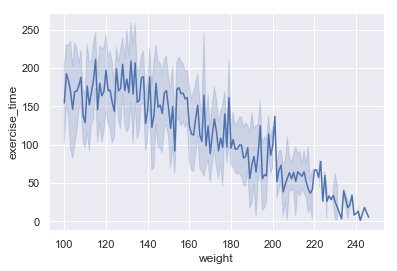

In [107]:
sns.lineplot('weight','exercise_time',data=df);

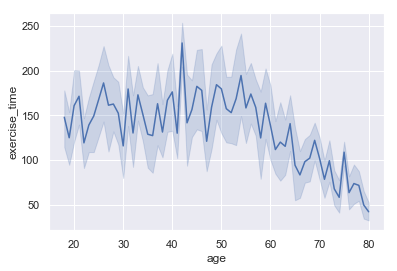

In [95]:
sns.lineplot('age','exercise_time',data=df);

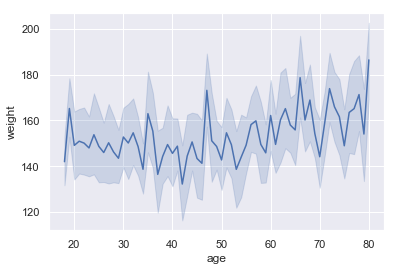

In [106]:
sns.lineplot('age','weight',data=df);

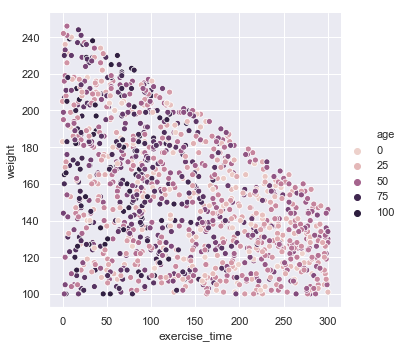

In [121]:
sns.relplot(x='exercise_time', y='weight', hue='age',data=df);

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
    * Age is continuous
    * Weight is discrete
    * Exercise time is continuous (time and age are similar constructs) 
2.  What are the relationships between the variables?
    * Young folks exercise more! 
    * People who weigh less exercise more! 
    * There isn't a blatant correlation between your age and weight
3.  Which relationships are "real", and which spurious?
    * The relationship between exercise time and weight is real 
    * The relationship between age and weight is spurious 
    * The relationship between exercise time and age is real


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)